# TimeCopilot

### Import libraries

In [1]:
! pip install TimeCopilot
import pandas as pd

from timecopilot import TimeCopilotForecaster
from timecopilot.models.foundation.chronos import Chronos
from timecopilot.models.foundation.moirai import Moirai
from timecopilot.models.foundation.timesfm import TimesFM
from timecopilot.models.stats import AutoARIMA, SeasonalNaive

from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mase, scaled_crps

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


In [2]:
# Load your Nixtla/TimeCopilot-format panel
df = pd.read_csv("downsampled_df.csv", parse_dates=["ds"])

print(df.head())
print("Number of series:", df["unique_id"].nunique())

  unique_id         ds          y
0      10_2 2010-02-05  123952.48
1      10_2 2010-02-12  119209.48
2      10_2 2010-02-19  121430.80
3      10_2 2010-02-26  120292.15
4      10_2 2010-03-05  113163.91
Number of series: 40


### Plot the Data

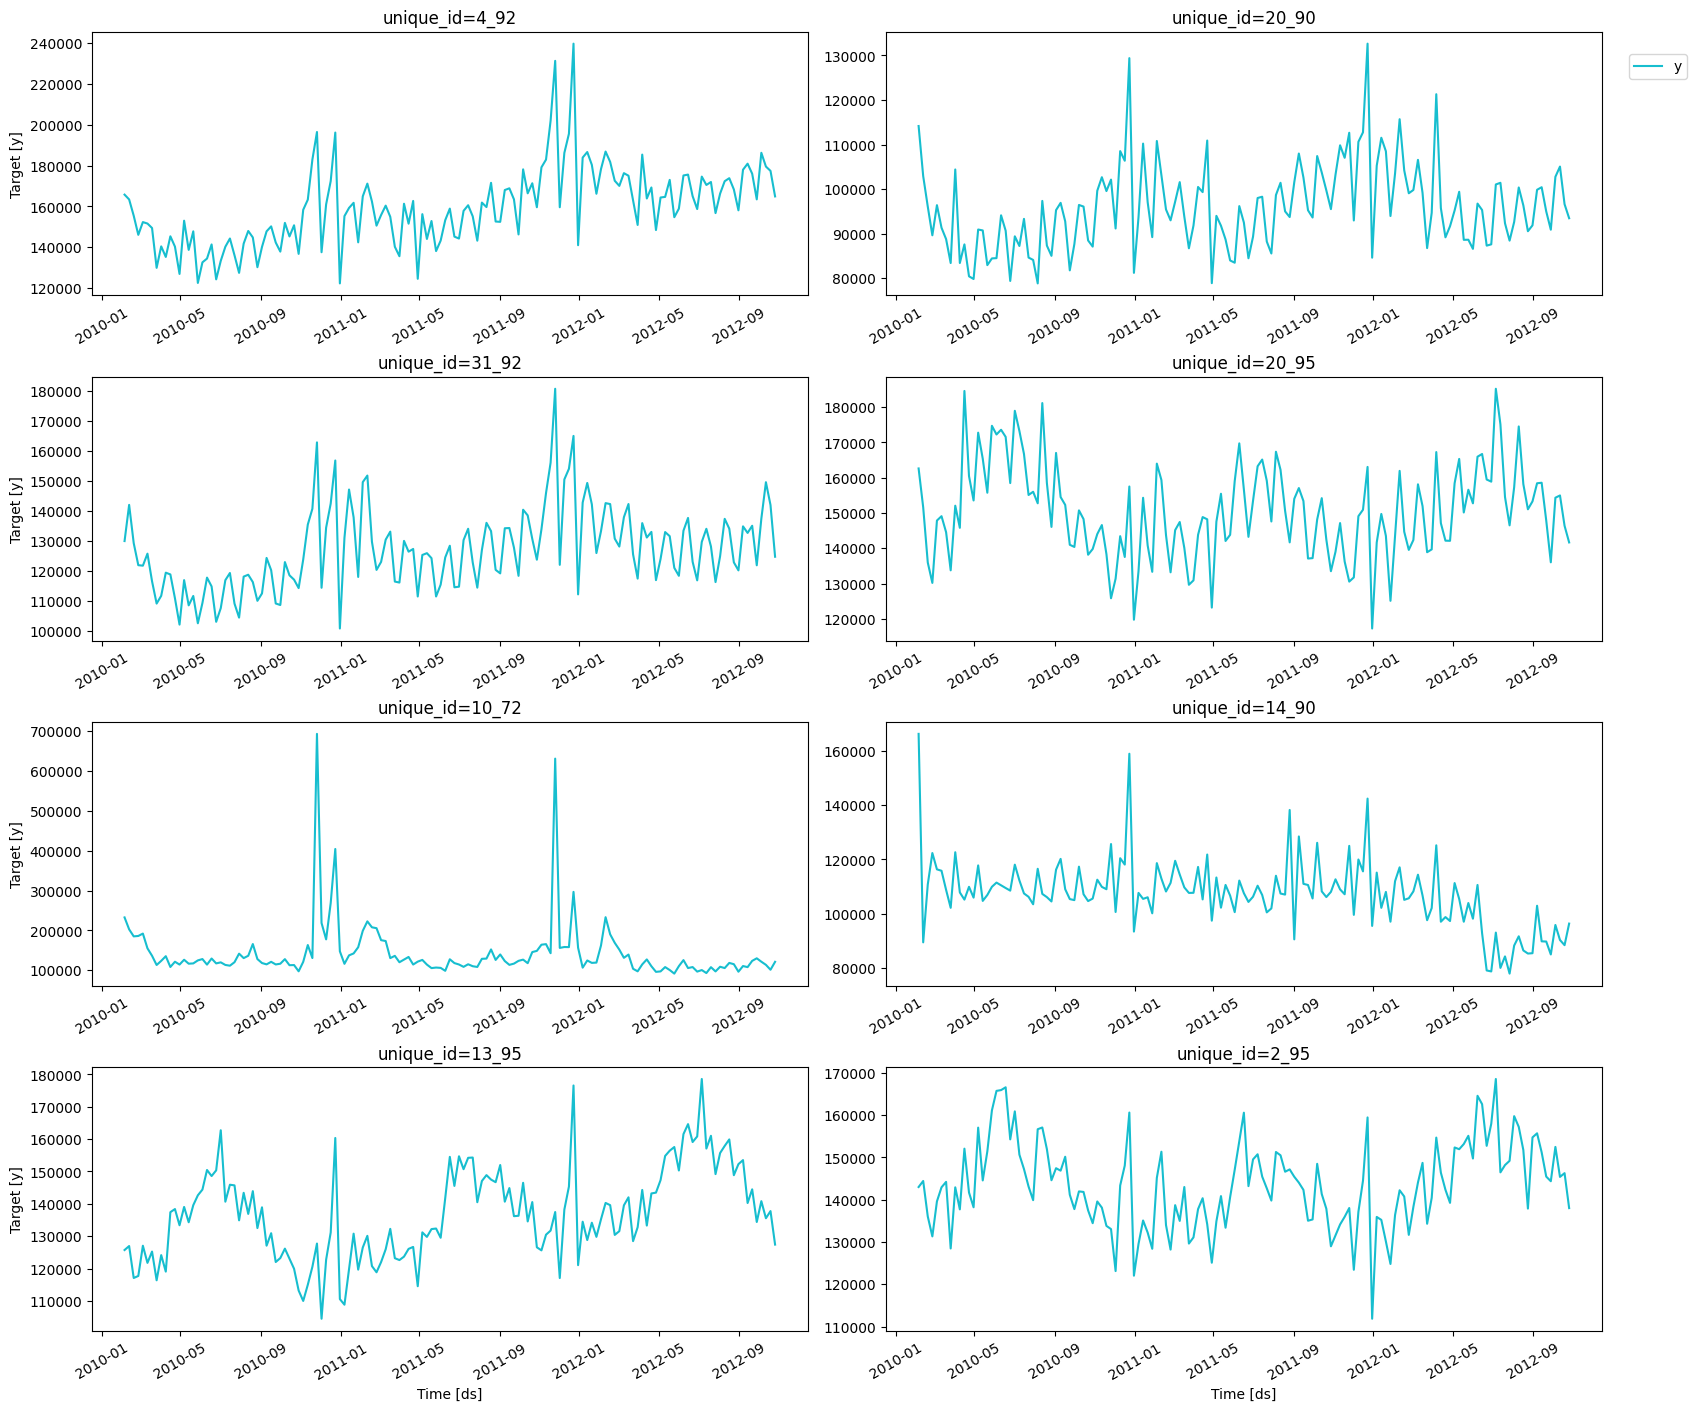

In [3]:
TimeCopilotForecaster.plot(df)

### Create a TimeCoPilotForecaster

In [4]:
tcf = TimeCopilotForecaster(
    models=[
        AutoARIMA(),
        Chronos(repo_id="amazon/chronos-bolt-small"),
        Moirai(),
        TimesFM(repo_id="google/timesfm-2.5-200m-pytorch", alias="TimesFM-2.5"),
        TimesFM(repo_id="google/timesfm-2.0-500m-pytorch", alias="TimesFM-2.0"),
        SeasonalNaive(season_length=52),  # weekly data ≈ yearly seasonality
    ]
)

### Generate forecast via cross-validation

In [ ]:
level = [0, 20, 40, 60, 80]

cv_df = tcf.cross_validation(
    df=df,
    h=12,         # 12 weeks ahead
    level=level,
    freq="W-FRI"  # Friday weekly data
)

1it [00:36, 36.28s/it]
0it [00:00, ?it/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:/usr/local/lib/python3.12/dist-packages/chronos/chronos_bolt.py:	Quantiles to be predicted ([0.09999999999999998, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) are not within the range of quantiles that Chronos-Bolt was trained on ([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]). Quantile predictions will be set to the minimum/maximum levels at which Chronos-Bolt was trained on. This may significantly affect the quality of the predictions.

 33%|███▎      | 1/3 [00:01<00:02,  1.15s/it]WARNING:/usr/local/lib/python3.12/dist-packages/chronos/chronos_bolt.py:	Quantiles to be predicted ([0.09999999999999998, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]) are not within the range of quantiles that Chronos-Bolt was trained on ([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]). Quantile predictions will be set to the minimum/maximum levels at which Chronos-Bolt was trained on. This may significantly affect the quality of the predictions.

 67%|██████▋   | 2/3 [0

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

### Plot results

In [ ]:
tcf.plot(
    df,
    cv_df.drop(columns=["cutoff", "y"]),
    level=[40, 60, 80]
)

### Evaluation

In [ ]:
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mase, scaled_crps

In [ ]:
# Determine training period based on the first cutoff used in cross-validation
first_cutoff = cv_df["cutoff"].min()

train_df = df[df["ds"] <= first_cutoff]
print("Train period ends at:", first_cutoff)

In [ ]:
eval_df = evaluate(
    cv_df.drop(columns=["cutoff"]),
    train_df=tc_df,
    metrics=[partial(mase, seasonality=52), scaled_crps], # weekly seasonality ≈ 52
    level=level,
)

summary = (
    eval_df.groupby("metric")
           .mean(numeric_only=True)
           .T
           .sort_values(by="scaled_crps")
           .round(3)
)

print(summary)